<a href="https://colab.research.google.com/github/Mervvick/AI_Autoencoder_Lite/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%D0%91%D0%B0%D0%B7%D0%BE%D0%B2%D1%8B%D0%B9_%D0%B1%D0%BB%D0%BE%D0%BA_%7C_%D0%90%D1%80%D1%85%D0%B8%D1%82%D0%B5%D0%BA%D1%82%D1%83%D1%80%D0%B0_%D0%B0%D0%B2%D1%82%D0%BE%D0%BA%D0%BE%D0%B4%D0%B8%D1%80%D0%BE%D0%B2%D1%89%D0%B8%D0%BA%D0%B0_(Autoencoder)_%7C_%D0%94%D0%97_Lite_%7C_%D0%A3%D0%98%D0%98%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Задание

Добейтесь на автокодировщике с 2-мерным скрытым пространством на 3-х цифрах: 0, 1 и 3 – ошибки MSE**<0.034** на скорости обучения **0.001** на **10-й эпохе**.

## Импорт библиотек


In [1]:
# Работа с операционной системой
import os

# Отрисовка графиков
import matplotlib.pyplot as plt

# Операции с путями
import glob

# Работа с массивами данных
import numpy as np

# Слои
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization, Concatenate

# Модель
from tensorflow.keras import Model

# Загрузка модели
from tensorflow.keras.models import load_model

# Датасет
from tensorflow.keras.datasets import mnist

# Оптимизатор для обучения модели
from tensorflow.keras.optimizers import Adam

# Коллбэки для выдачи информации в процессе обучения
from tensorflow.keras.callbacks import LambdaCallback

%matplotlib inline

## Утилиты

Функция-коллбэк. Отрисовывает объекты в скрытом пространстве

In [2]:
def ae_on_epoch_end(epoch, logs):
    print('\n________________________')
    print(f'*** ЭПОХА: {epoch+1}, loss: {logs["loss"]} ***')
    print('________________________')

    # Получение картинки латентного пространства в конце эпохи и запись в файл
    # Задание числа пикселей на дюйм
    plt.figure(dpi=100)

    # Предсказание енкодера на тренировочной выборке
    predict = encoder.predict(X_train)

    # Создание рисунка: множество точек на плоскости 3-х цветов (3-х классов)
    scatter = plt.scatter(predict[:,0,],predict[:,1], c=y_train, alpha=0.6, s=5)

    # Создание легенды
    legend2 = plt.legend(*scatter.legend_elements(), loc='upper right', title='Классы')

    # Сохранение картинки с названием, которого еще нет
    paths = glob.glob('*.jpg')
    plt.savefig(f'image_{str(len(paths))}.jpg')

    # Отображение. Без него рисунок не отрисуется
    plt.show()


ae_callback = LambdaCallback(on_epoch_end=ae_on_epoch_end)

Удаление изображений. Применять при обучении новой модели, чтобы не было путаницы в картинках.

In [3]:
def clean():
  # Получение названий всех картинок
  paths = glob.glob('*.jpg')

  # Удаление всех картинок по полученным путям
  for p in paths:
    os.remove(p)

# Удаление всех картинок
clean()

## Загрузка данных

In [4]:
# Загрузка датасета
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [5]:
# Нормировка
X_train = X_train.astype('float32')/255.
X_train = X_train.reshape(-1, 28, 28, 1)

In [6]:
# Выбор визуализируемых классов (цифр) и формирование подвыборок для них по маске
numbers = [0, 1, 3]
mask = np.array([(i in numbers) for i in y_train])
X_train = X_train[mask]
y_train = y_train[mask]

## Создание модели и обучение

In [7]:
# Ваше решение (2-х мерное скрытое пр-во, MSE < 0.034 на 10-й эпохе при LR = 0.001)
LATENT_DIM = 2
EPOCHS = 10

In [8]:
encoder_inputs = Input(X_train.shape[1:]) # (28, 28, 1)
x = Conv2D(16, (3, 3), activation = 'relu', padding = 'same', dilation_rate = 2)(encoder_inputs) # (28, 28, 16)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation = 'relu', padding = 'same', dilation_rate = 2)(x) # (28, 28, 32)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation = 'relu', padding = 'same', strides = 2)(x) # (14, 14, 32)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation = 'relu', padding = 'same', dilation_rate = 2)(x) # (7, 7, 64)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation = 'relu', padding = 'same', strides = 2)(x) # (7, 7, 64)
x = BatchNormalization()(x)
pre_flatter_shape = x.shape[1:]

x = Flatten()(x) # (3136)
flat_shape = x.shape[1]

x = Dense(512, activation = 'relu')(x) # (1024)
x = Dense(256, activation = 'relu')(x) # (256)
x = Dense(64, activation = 'relu')(x) # (64)
encoder_outputs = Dense(LATENT_DIM, activation = 'relu')(x) # (2)



decoder_inputs = Input(LATENT_DIM) # (2)
# decoder_inputs = Dense(2)(encoder_outputs)
x = Dense(64, activation = 'relu')(decoder_inputs) # (64)
x = Dense(256, activation = 'relu')(x) # (256)
x = Dense(512, activation = 'relu')(x) # (1024)
x = Dense(flat_shape, activation = 'relu')(x) # (3136)
x = Reshape(pre_flatter_shape)(x) # (7, 7, 64)

x = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(x) # (7, 7, 64)
x = BatchNormalization()(x)
x = Conv2DTranspose(64, (3, 3), activation = 'relu', padding = 'same', strides = 2)(x) # (14, 14, 64)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation = 'relu', padding = 'same',)(x) # (14, 14, 32)
x = BatchNormalization()(x)
x = Conv2DTranspose(32, (3, 3), activation = 'relu', padding = 'same', strides = 2)(x) # (28, 28, 32)
x = BatchNormalization()(x)
x = Conv2DTranspose(16, (3, 3), activation = 'relu', padding = 'same')(x) # (28, 28, 16)
x = BatchNormalization()(x)
decoder_outputs = Conv2D(1, (3, 3), activation = 'sigmoid', padding = 'same')(x) # (28, 28, 1)

encoder = Model(encoder_inputs, encoder_outputs)
decoder = Model(decoder_inputs, decoder_outputs)
# encoder.summary()
# decoder.summary()
autoencoder = Model(encoder_inputs, decoder(encoder(encoder_inputs)))


autoencoder.compile(optimizer = Adam(0.001),
                    loss = 'MSE',
                    metrics = ['accuracy']
                    )

autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 model (Functional)          (None, 2)                 1824354   
                                                                 
 model_1 (Functional)        (None, 28, 28, 1)         1864353   
                                                                 
Total params: 3,688,707
Trainable params: 3,687,875
Non-trainable params: 832
_________________________________________________________________


Epoch 1/10
1175/1175 [==============================] - ETA: 0s - loss: 0.0438 - accuracy: 0.8032
________________________
*** ЭПОХА: 1, loss: 0.043794576078653336 ***
________________________
588/588 [==============================] - 2s 2ms/step


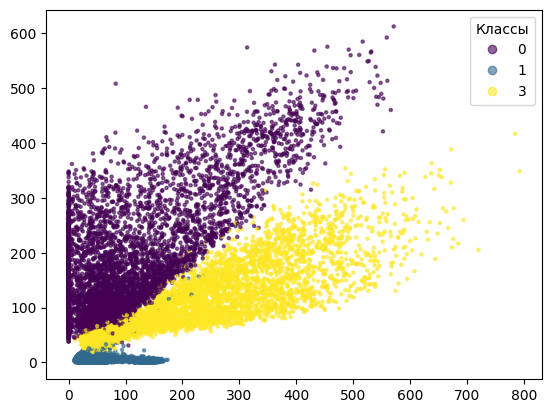

1175/1175 [==============================] - 38s 18ms/step - loss: 0.0438 - accuracy: 0.8032
Epoch 2/10
1175/1175 [==============================] - ETA: 0s - loss: 0.0329 - accuracy: 0.8087
________________________
*** ЭПОХА: 2, loss: 0.03286554664373398 ***
________________________
588/588 [==============================] - 1s 2ms/step


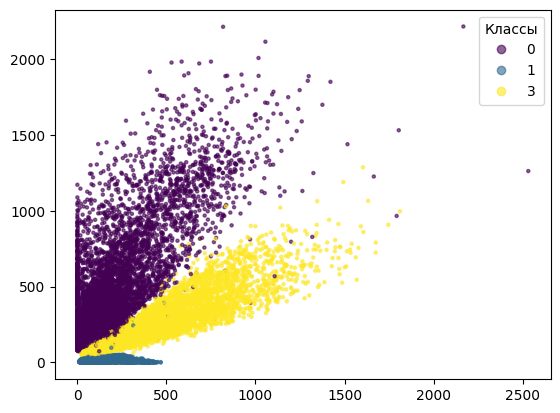

1175/1175 [==============================] - 19s 16ms/step - loss: 0.0329 - accuracy: 0.8087
Epoch 3/10
1173/1175 [============================>.] - ETA: 0s - loss: 0.0315 - accuracy: 0.8095
________________________
*** ЭПОХА: 3, loss: 0.031459588557481766 ***
________________________
588/588 [==============================] - 1s 2ms/step


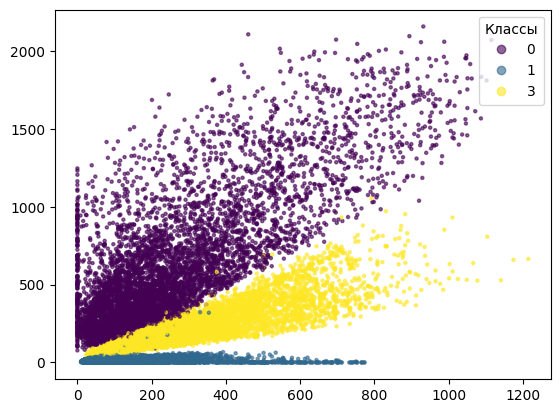

1175/1175 [==============================] - 20s 17ms/step - loss: 0.0315 - accuracy: 0.8095
Epoch 4/10
1173/1175 [============================>.] - ETA: 0s - loss: 0.0305 - accuracy: 0.8101
________________________
*** ЭПОХА: 4, loss: 0.030516386032104492 ***
________________________
588/588 [==============================] - 2s 3ms/step


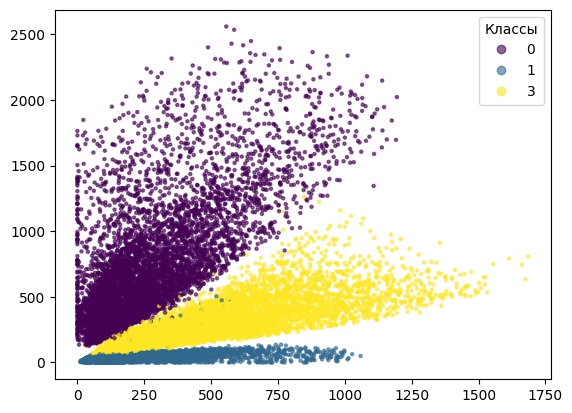

1175/1175 [==============================] - 21s 18ms/step - loss: 0.0305 - accuracy: 0.8101
Epoch 5/10
1172/1175 [============================>.] - ETA: 0s - loss: 0.0299 - accuracy: 0.8104
________________________
*** ЭПОХА: 5, loss: 0.029857361689209938 ***
________________________
588/588 [==============================] - 1s 3ms/step


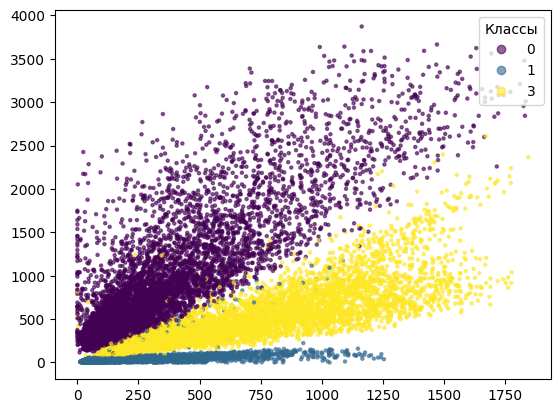

1175/1175 [==============================] - 20s 17ms/step - loss: 0.0299 - accuracy: 0.8104
Epoch 6/10
1173/1175 [============================>.] - ETA: 0s - loss: 0.0296 - accuracy: 0.8106
________________________
*** ЭПОХА: 6, loss: 0.029646651819348335 ***
________________________
588/588 [==============================] - 2s 3ms/step


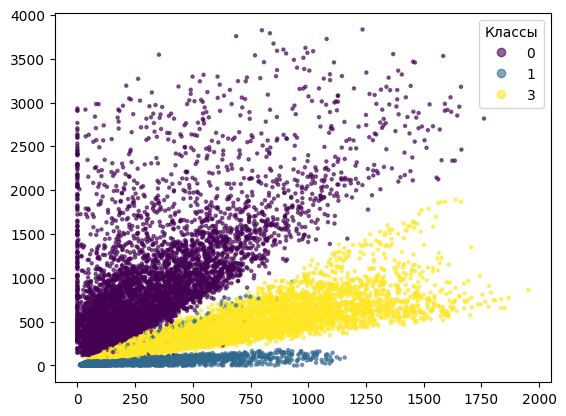

1175/1175 [==============================] - 23s 19ms/step - loss: 0.0296 - accuracy: 0.8106
Epoch 7/10
1175/1175 [==============================] - ETA: 0s - loss: 0.0291 - accuracy: 0.8109
________________________
*** ЭПОХА: 7, loss: 0.029129350557923317 ***
________________________
588/588 [==============================] - 2s 3ms/step


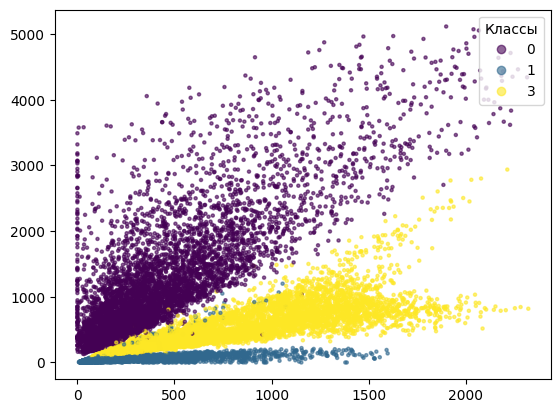

1175/1175 [==============================] - 21s 18ms/step - loss: 0.0291 - accuracy: 0.8109
Epoch 8/10
1173/1175 [============================>.] - ETA: 0s - loss: 0.0290 - accuracy: 0.8110
________________________
*** ЭПОХА: 8, loss: 0.029033251106739044 ***
________________________
588/588 [==============================] - 2s 3ms/step


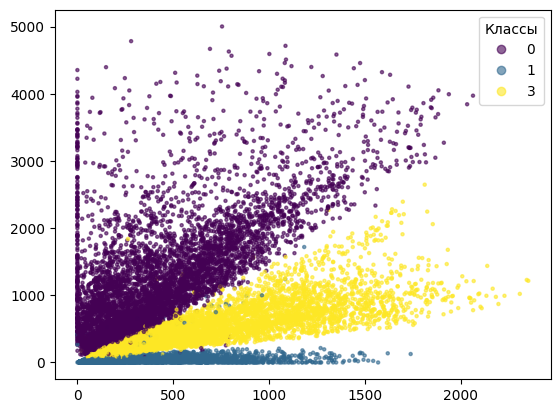

1175/1175 [==============================] - 22s 19ms/step - loss: 0.0290 - accuracy: 0.8110
Epoch 9/10
1173/1175 [============================>.] - ETA: 0s - loss: 0.0286 - accuracy: 0.8113
________________________
*** ЭПОХА: 9, loss: 0.028607862070202827 ***
________________________
588/588 [==============================] - 2s 4ms/step


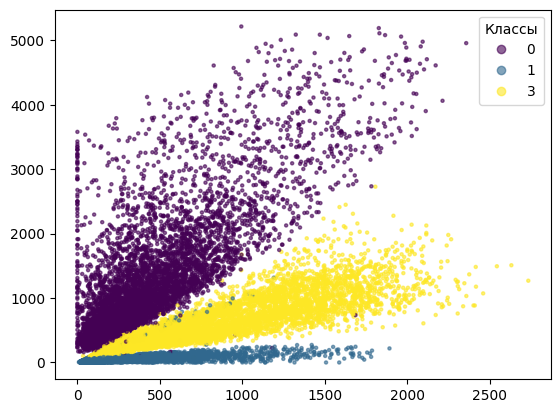

1175/1175 [==============================] - 22s 19ms/step - loss: 0.0286 - accuracy: 0.8113
Epoch 10/10
1175/1175 [==============================] - ETA: 0s - loss: 0.0283 - accuracy: 0.8115
________________________
*** ЭПОХА: 10, loss: 0.028286701068282127 ***
________________________
588/588 [==============================] - 2s 3ms/step


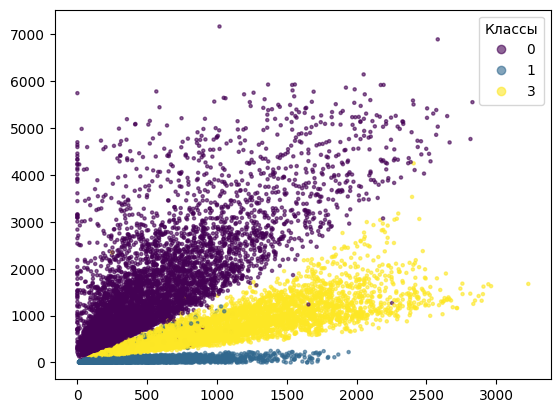

1175/1175 [==============================] - 21s 18ms/step - loss: 0.0283 - accuracy: 0.8115


In [9]:
history = autoencoder.fit(X_train,
                          X_train,
                          batch_size = 16,
                          epochs = EPOCHS,
                          verbose = 1,
                          callbacks = [ae_callback],
                          shuffle = True)

В результате работы удалось добиться MSE ~0.028 на 10 эпохе обучения при скорости обучения 0.001.